In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Density.Free
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Sequential.Coroutine
import Control.Monad.Bayes.Inference.SMC
import Control.Monad.Bayes.Inference.RMSMC
import Control.Monad.Bayes.Inference.PMMH


import qualified Data.Text as T
import Numeric.Log
import Control.Arrow (first,second)
import Control.Monad
import Control.Applicative
import Control.Monad.Bayes.Class 
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Traced
import Control.Monad.Bayes.Weighted
import Graphics.Vega.VegaLite hiding (density)
import qualified Graphics.Vega.VegaLite as VL
import IHaskell.Display.Hvega (vlShow)

import qualified Pipes.Prelude as P
import qualified Pipes as P
import Pipes (Producer, (>->), MonadTrans (lift))

:l Plotting.hs

# Combining SMC and MCMC

Monad-bayes offers several more advanced inference methods, which are modular combinations of `SMC` and `MCMC`. 

## Resample Move Sequential Monte Carlo (RMSMC)

RMSMC is fundamentally an SMC technique. It creates and updates a population of weighted samples. The clever part is that after resampling, the update step uses MCMC to perform a walk on each particle, which updates the population efficiently.

To motivate this more sophisticated inference method, let's pick a relatively hard inference problem: inferring the position of a moving point mass from measurements of its bearings.

Here it is in practice:

todo: 
visualize the mcmc steps to show that they're efficient

In [2]:
-- calculate the bearing (the angle) of a point
bearing (x, y) = atan2 y x

latent :: MonadSample m => Producer (Double,Double) m ()
latent = do
    let velocity_var = 1e-5
    initialPosition <- lift $ liftA2 (,) (normal 0.01 0.01) (normal 0.95 0.01)
    initialVelocity <- lift $ liftA2 (,) (normal 0.002 0.01) (normal (-0.013) 0.01)
    let step ((qx,qy), (vx,vy)) = do
        vxNew <- normal vx (sqrt velocity_var)
        vyNew <- normal vy (sqrt velocity_var)
        return ((qx + vx, qy + vy), (vxNew, vyNew))
    P.unfoldr (\x -> Right <$> dup (step x)) (initialPosition, initialVelocity) >-> P.map fst
    
    where 
    dup :: Monad m => m b -> m (b, b)
    dup mx = do
        x <- mx
        return (x,x)

measurementNoise = 0.005


observation :: MonadSample m => P.Pipe (Double, Double) Double m ()
observation = P.mapM \position -> normal (bearing position) measurementNoise


model :: MonadInfer m => [Double] -> Producer (Double, Double) m ()
model observations = zipWithM likelihood latent observationStream where
    
    observationStream = P.each observations
    measurement_noise = 0.005
    likelihood (pos, obs) = factor $ normalPdf (bearing pos) measurement_noise obs
    zipWithM f p1 p2 = P.zip p1 p2 >-> P.chain f >-> P.map fst

In [47]:
positions = sampleSTfixed $ P.toListM (latent >-> P.take 2)

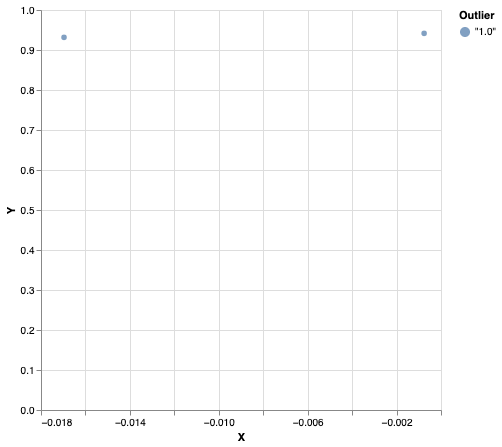

In [48]:
plotVega ( zip positions $ Prelude.repeat $ T.pack "1.0")

In [7]:
-- d positions = mconcat [
--     circle 0.01 # translate (V2 x y) <> hrule 0.1 # rotateBy ( bearing (1, 1)  )
--     -- <> (circle 0.1 # translate 5 # named ("foo" <> (show (x,y)))))
--     -- # connect (show (x,y)) ("foo" <> (show (x,y)))
--     | ((x,y),i) <- zip positions [1..]]
-- diagram $ d positions

: 

In [49]:
observations <- sampleIO $ mapM (\position -> normal (bearing position) measurementNoise) positions

Line 1: Redundant bracket
Found:
([1.0 .. ])
Why not:
[1.0 .. ]

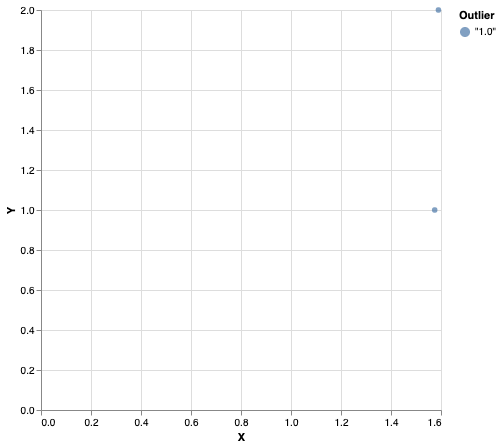

In [50]:
plotVega ( zip (zip observations ([1.0..])) $ Prelude.repeat $ T.pack "1.0")

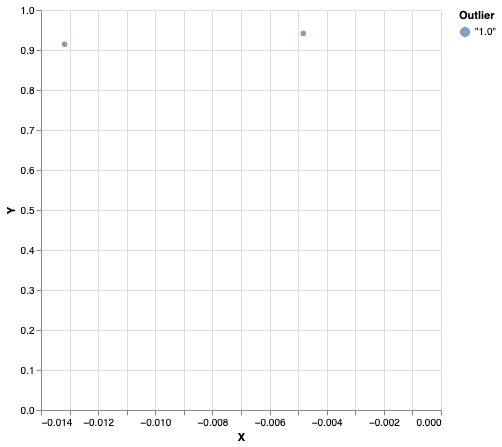

In [51]:
s <- sampleIO $ prior $ mh 1000 $ P.toListM $ model observations

plotVega $ zip (head s) (Prelude.repeat $ T.pack $ show 1.0)

In [54]:
s <- sampleIOfixed $ runPopulation $ smcSystematic 2 1 $ P.toListM $ model observations

-- s <- sampleIOfixed $ runPopulation $ smcSystematic 0 1 $ bernoulli 0.5

In [55]:
import Data.List
snd $ head s

8.606562776235572

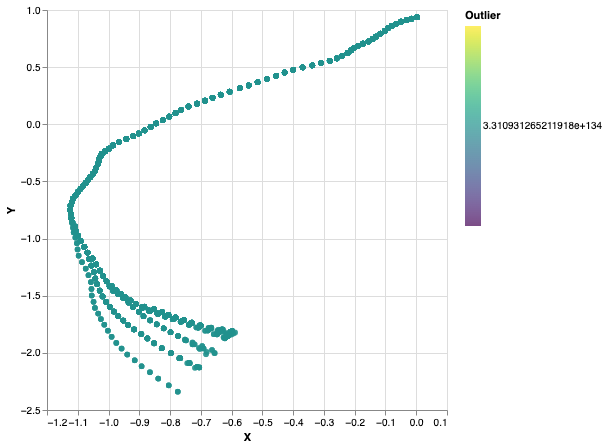

In [26]:
a = (\(x,d) -> zip x (Prelude.repeat $ ln $ exp d)) =<< s
-- b = join (replicate 1000 ((ln . exp . snd) <$> s))
-- s' = zip a ([1.0..])

plotVega $ take 10000 a


In [182]:
-- samplesSingle <- sampleIO $ P.toListM (latent >-> P.map fst >-> P.take 100)
-- observationsSingle = fmap (\((x,y)) -> atan2 y x) samplesSingle



In [ ]:
s <- sampleIOfixed $ runPopulation $ rmsmcBasic 100 10 1000 $ P.toListM $ model observations

In [ ]:
a = (\(x,d) -> zip x (Prelude.repeat $ ln $ exp d)) =<< s

plotVega $ take 50000 a

# Particle Marginal Metropolis Hastings (PMMH)

PMMH is fundamentally an MCMC technique. It performs a random walk through parameter space, but to estimate the likelihood at each step, it uses an unbiased estimate from a population of samples. We'll reuse the regression with outliers example.

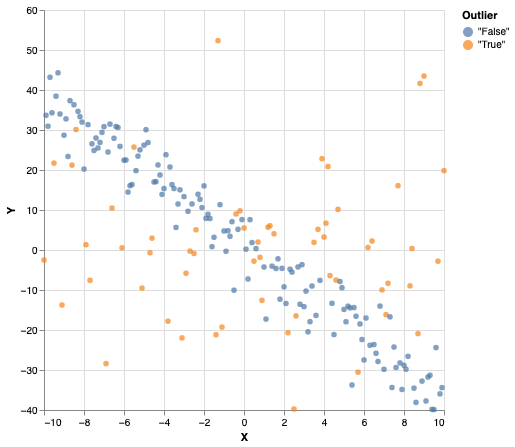

In [34]:
paramPrior = do
    slope <- normal 0 2
    intercept <- normal 0 2
    noise <- gamma 7 7
    prob_outlier <- uniform 0 0.5 
    return (slope, intercept, noise, prob_outlier)

forward (slope, intercept, noise, probOutlier) x = do
    isOutlier <- bernoulli probOutlier
    let meanParams = if isOutlier
                    then (0, 20)
                    else (x*slope + intercept, sqrt noise)
    return (meanParams, isOutlier)

regressionWithOutliersData :: (MonadSample m, Traversable t) => t Double -> m (t ((Double, Double), Bool))
regressionWithOutliersData xs = do
    params <- paramPrior

    forM xs \x -> do
        ((mu, std), isOutlier) <- forward params x
        y <- normal mu std
        return ((x, y), isOutlier)
        
range = [-10,-9.9..10] :: [Double]
samples <- sampleIOfixed $ regressionWithOutliersData range
plotVega (fmap (second (T.pack . show)) samples)


In [35]:
regressionWithOutliers xs ys params = do
    
    outliers <- forM (zip xs ys) \(x, y) -> do
        ((mu, std), isOutlier) <- forward params x
        factor $ normalPdf mu std y
        return isOutlier
    return (params, outliers)

In [36]:
mhRuns <- sampleIOfixed $ prior $ pmmh 10 200 100
    paramPrior
    (regressionWithOutliers range (snd . fst <$> samples))

m = fmap (\((_,a), b) -> (a,b)) $ head mhRuns

In [37]:
outlierProb s = (\(x, y) ->   ln (exp (x / (x+y))) )
        <$> (foldr
    \(lb, d) li -> 
        [ if b then (num1+d, num2) else (num1,num2+d) | (b,(num1, num2)) <- zip lb li])
    (Prelude.repeat (0 :: Log Double,0 :: Log Double)) s

Line 2: Redundant bracket
Found:
(foldr
   \ (lb, d) li
     -> [if b then (num1 + d, num2) else (num1, num2 + d) |
           (b, (num1, num2)) <- zip lb li])
  (Prelude.repeat (0 :: Log Double, 0 :: Log Double))
Why not:
foldr
  \ (lb, d) li
    -> [if b then (num1 + d, num2) else (num1, num2 + d) |
          (b, (num1, num2)) <- zip lb li]
  (Prelude.repeat (0 :: Log Double, 0 :: Log Double))

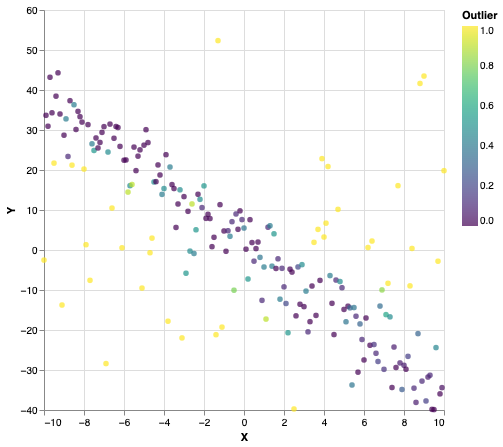

In [38]:
plotVega $ take 1000 (zip (fst <$> samples) (outlierProb m))

As the above plot shows, this works nicely: the `slope`, `intercept`, `noise` and `prob_outlier` variables are inferred by a random walk through the space, while the score to determine whether to accept a new proposed step in this walk is determined by a particle filter which guesses which points are outliers after each observation.

# $SMC^2$

The culmination of monad-bayes is $SMC^2$, which combines all the previous piece together into one inference algorithm.

It is $RMSMC$, but with the $MCMC$ walk performed using $PMMH$. 